# Neural Network

In [1]:
import sys
import pandas as pd
import time
import datetime
import random
from matplotlib import pyplot as plt

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE 

import numpy as np
from numpy import loadtxt
from numpy.random import seed

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
#from sklearn.pipeline import # Pipeline # make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Data preperation

In [2]:
# function to reset all RNG's to seed 23
def reset_random_seeds():
   tf.random.set_seed(23) # tensorflow's seed
   np.random.seed(23) # numpy's seed
   random.seed(23) # python's seed

In [3]:
# import data
data = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')
#data = data.head(1000)
length = data.shape[0]
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# select variables
cats_to_use = ['age', 'default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

In [5]:
# save lists of categorical and numerical variables
cat_cols = ['default', 'contact', 'month', 'poutcome', 'y']
num_cols = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']

# create column transformer to 1 one-hot-encode cat vars and 2 noralise num vars
ct = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_cols), # drop first column (reference)
    (StandardScaler(), num_cols),
)

# transform base table (pandas df -> numpy array)
base = ct.fit_transform(data)

# convert base table to p.df for ease of use (numpy array -> pandas df)
base_temp = pd.DataFrame(base, columns=ct.get_feature_names_out().tolist())
base_temp

,onehotencoder__default_unknown,onehotencoder__default_yes,onehotencoder__contact_telephone,onehotencoder__month_aug,onehotencoder__month_dec,onehotencoder__month_jul,onehotencoder__month_jun,onehotencoder__month_mar,onehotencoder__month_may,onehotencoder__month_nov,onehotencoder__month_oct,onehotencoder__month_sep,onehotencoder__poutcome_nonexistent,onehotencoder__poutcome_success,onehotencoder__y_yes,standardscaler__age,standardscaler__previous,standardscaler__emp.var.rate,standardscaler__euribor3m,standardscaler__nr.employed
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,0.648092,0.712460,0.331680
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.628993,-0.349494,0.648092,0.712460,0.331680
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.290186,-0.349494,0.648092,0.712460,0.331680
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.002309,-0.349494,0.648092,0.712460,0.331680
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,0.648092,0.712460,0.331680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.164336,-0.349494,-0.752343,-1.495186,-2.815697
41184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.573445,-0.349494,-0.752343,-1.495186,-2.815697
41185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.533034,-0.349494,-0.752343,-1.495186,-2.815697
41186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.381527,-0.349494,-0.752343,-1.495186,-2.815697


In [6]:
# check list of column names in base table
base_temp.columns.tolist()

['onehotencoder__default_unknown',
 'onehotencoder__default_yes',
 'onehotencoder__contact_telephone',
 'onehotencoder__month_aug',
 'onehotencoder__month_dec',
 'onehotencoder__month_jul',
 'onehotencoder__month_jun',
 'onehotencoder__month_mar',
 'onehotencoder__month_may',
 'onehotencoder__month_nov',
 'onehotencoder__month_oct',
 'onehotencoder__month_sep',
 'onehotencoder__poutcome_nonexistent',
 'onehotencoder__poutcome_success',
 'onehotencoder__y_yes',
 'standardscaler__age',
 'standardscaler__previous',
 'standardscaler__emp.var.rate',
 'standardscaler__euribor3m',
 'standardscaler__nr.employed']

In [7]:
# seperate base table into X and y and convert to numpy array (base pandas df -> y numpy array + X numpy array)
y = base_temp['onehotencoder__y_yes'].values
X = base_temp.drop(columns=['onehotencoder__y_yes']).values

# save and check dimensions of X 
(X_length, X_vars) = X.shape
X_length, X_vars

(41188, 19)

In [8]:
# create train/test split
train_features, test_features, train_targets, test_targets = train_test_split(X, y, test_size=0.2, random_state=23)

## The model
First make a function to create a complete keras model. These models can later be wrapped by a sklearn compatible classifier to be able to use sklearns functions on the model.

In [9]:
# function returns keras NN
def create_model(hiddenLayerOne=10, learnRate=0.01):
    # reset RNG's
    reset_random_seeds()
    
    # define model (input layer (X_vars-d) > hidden layer (12-d) > output layer (1-d))
    model = tf.keras.models.Sequential()
    model.add(Dense(hiddenLayerOne, input_dim=X_vars, activation='sigmoid')) # input + hidden layer: 12 nodes + relu (TUNE #NODES!)
    model.add(Dense(1, activation='sigmoid')) # output layer: 1 node + sigmoid

    # compile model (Adam performs well (source?), AUC for comparison)
    model.compile(
        loss='binary_crossentropy', 
        optimizer=Adam(learning_rate=learnRate), 
        metrics=['accuracy']) # tf.keras.metrics.AUC()
    
    # return compiled model
    return model

### Hyperparameter tuning using grid search - UNDERSAMPLING IN FOLD
This algorithm runs some model configurations on a dataset of 902 observations in approximately 50 minutes.

In [10]:
# for model timing
time.ctime()

'Wed Apr  6 17:45:21 2022'

In [ ]:
# define hyperparameter search space
hiddenLayerOne = [3, 6, 10, 15]
learnRate = [1e-1, 1e-2, 1e-3]
batchSize = [16, 32, 64, 128]
epochs = [10, 30, 50, 80]

# create dictionary from search space
grid = dict(
    kerasclassifier__hiddenLayerOne=hiddenLayerOne,
    kerasclassifier__learnRate=learnRate,
    kerasclassifier__batch_size=batchSize,
    kerasclassifier__epochs=epochs
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10)

# create imbalanced learn pipeline
imba_pipeline = make_pipeline(NearMiss(version=1), KerasClassifier(build_fn=create_model, verbose=0))

# create grid search model with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=imba_pipeline, param_grid=grid, n_jobs=1, cv=cv, verbose=5, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

# for model timing
time.ctime()

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Instructions for updating:
Please use `model.predict()` instead.
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.703 total time=   6.5s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.748 total time=   4.4s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.754 total time=   5.5s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.725 total time=   5.6s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.695 total time=   4.3s
[CV 6

[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.706 total time=   5.0s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.744 total time=   4.6s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.703 total time=   5.0s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.763 total time=   4.9s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.704 total time=   5.6s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__lea

[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.732 total time=  14.0s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.727 total time=  14.4s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.695 total time=  15.7s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.716 total time=  16.6s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.737 total time=  15.9s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__lea

[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.708 total time=  34.1s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.719 total time=  33.9s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.758 total time=  30.2s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.751 total time=  31.2s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.744 total time=  34.1s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier_

[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.732 total time=  37.0s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.707 total time=  36.8s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.743 total time=  33.3s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.691 total time=  33.8s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.709 total time=  35.5s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__l

[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.748 total time=  29.5s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.727 total time=  31.1s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.727 total time=  29.0s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.750 total time=  25.7s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.716 total time=  27.6s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclass

[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.739 total time=  33.7s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.735 total time=  32.4s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.727 total time=  34.6s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.700 total time=  34.8s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.706 total time=  37.6s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__lear

[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.768 total time=  34.3s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.712 total time=  45.1s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.698 total time=  39.2s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.739 total time=  37.5s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.716 total time=  37.4s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=15, kerasclassifier

[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.709 total time= 1.0min
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.734 total time=  28.5s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.708 total time=  18.8s
[CV 9/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.758 total time=  17.7s
[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.710 total time=  22.3s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__lea

[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.722 total time=  20.7s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.724 total time=  20.5s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.684 total time=  24.9s
[CV 6/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.688 total time=  21.9s
[CV 7/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.732 total time=  21.9s
[CV 8/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=10, kerasclassifier__lea

[CV 10/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.684 total time=  19.7s
[CV 1/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.718 total time=  20.2s
[CV 2/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.764 total time=  18.4s
[CV 3/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.749 total time=  25.7s
[CV 4/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.740 total time=  19.9s
[CV 5/10] END kerasclassifier__batch_size=16, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclass

[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.731 total time=   3.0s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.699 total time=   6.4s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.757 total time=   3.9s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.707 total time=   3.3s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.718 total time=   3.5s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRa

[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.745 total time=   3.3s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.727 total time=   3.2s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.729 total time=   3.1s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.747 total time=   3.0s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.713 total time=   3.2s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclass

[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.715 total time=   4.9s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.755 total time=   4.8s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.752 total time=   5.2s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.746 total time=   4.8s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.718 total time=   5.1s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__lear

[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.763 total time=  15.3s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.712 total time=  14.6s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.714 total time=  14.4s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.743 total time=  15.2s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.720 total time=  18.6s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=10, kerasclassifier__

[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.698 total time=  19.2s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.733 total time=  14.7s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.694 total time=  17.7s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.757 total time=  15.9s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.702 total time=  15.7s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifie

[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.731 total time=  27.9s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.723 total time=  27.5s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.691 total time=  36.3s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.697 total time=  29.8s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.734 total time=  28.5s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate

[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.700 total time=  29.6s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.722 total time=  31.5s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.761 total time=  32.9s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.751 total time=  29.8s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.745 total time=  28.9s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclass

[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.727 total time=  18.2s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.708 total time=  16.8s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.748 total time=  17.3s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.697 total time=  18.3s
[CV 1/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.707 total time=  17.3s
[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRa

[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.723 total time=  20.1s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.720 total time=  18.0s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.750 total time=  20.6s
[CV 8/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.715 total time=  21.6s
[CV 9/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.766 total time=  23.5s
[CV 10/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier

[CV 2/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.738 total time=  22.9s
[CV 3/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.721 total time=  19.9s
[CV 4/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.710 total time=  19.8s
[CV 5/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.690 total time=  17.6s
[CV 6/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.696 total time=  20.3s
[CV 7/10] END kerasclassifier__batch_size=32, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier

[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.767 total time=   4.2s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.725 total time=   4.8s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.715 total time=   4.3s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.756 total time=   3.5s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.1;, score=0.742 total time=   3.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=6, kerasclassifier__lear

[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.746 total time=   5.2s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.712 total time=   4.9s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.764 total time=   5.6s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.707 total time=   4.5s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.001;, score=0.722 total time=   4.2s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifi

[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.729 total time=   5.8s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.719 total time=   6.0s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.697 total time=   5.8s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.732 total time=   5.6s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.703 total time=   5.5s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate

[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.759 total time=   6.2s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.750 total time=   5.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.744 total time=   6.0s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.724 total time=   4.7s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.727 total time=   5.0s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier_

[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.739 total time=   5.6s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.691 total time=   4.7s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.715 total time=   5.0s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.752 total time=   5.2s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.01;, score=0.741 total time=   5.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier_

[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.725 total time=   7.9s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.748 total time=   7.9s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.712 total time=   7.6s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.761 total time=   7.9s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.711 total time=   8.2s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=6, kerasclassifier

[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.724 total time=   8.5s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.700 total time=   8.0s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.705 total time=   7.7s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.732 total time=   8.9s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.705 total time=   8.4s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=10, kerasclassifier

[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.698 total time=  13.3s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.757 total time=  11.1s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.736 total time=  12.1s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.715 total time=  10.4s
[CV 5/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.705 total time=  10.7s
[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate

[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.758 total time=  10.7s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.695 total time=   9.0s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.721 total time=  13.2s
[CV 2/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.760 total time=  12.1s
[CV 3/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.001;, score=0.751 total time=  10.7s
[CV 4/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=6, kerasclassifier__

[CV 6/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.691 total time=   9.8s
[CV 7/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.730 total time=   9.9s
[CV 8/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.677 total time=   9.2s
[CV 9/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.738 total time=   9.8s
[CV 10/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.687 total time=   9.5s
[CV 1/10] END kerasclassifier__batch_size=64, kerasclassifier__epochs=80, kerasclassifier__hiddenLayerOne=15, kerasclassifier__le

[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.760 total time=   5.7s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.754 total time=   3.5s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.742 total time=   4.0s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.746 total time=   3.6s
[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.759 total time=   3.7s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=3, kerasclass

[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.1;, score=0.697 total time=   3.9s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.719 total time=   3.4s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.762 total time=   3.2s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.748 total time=   6.2s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclassifier__learnRate=0.01;, score=0.744 total time=   4.2s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=10, kerasclas

[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.757 total time=   3.2s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.721 total time=   3.2s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.771 total time=   3.1s
[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=10, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.001;, score=0.730 total time=   3.1s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.1;, score=0.719 total time=   3.8s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=3, kerascl

[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.741 total time=   3.3s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.722 total time=   4.6s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.712 total time=   4.3s
[CV 7/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.744 total time=   4.8s
[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier__learnRate=0.01;, score=0.707 total time=   4.7s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=6, kerasclassifier

[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.692 total time=   3.4s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.742 total time=   3.4s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.719 total time=   3.2s
[CV 4/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.724 total time=   3.2s
[CV 5/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifier__learnRate=0.1;, score=0.705 total time=   3.4s
[CV 6/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=30, kerasclassifier__hiddenLayerOne=15, kerasclassifie

[CV 8/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.712 total time=   3.9s
[CV 9/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.771 total time=   3.5s
[CV 10/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.01;, score=0.707 total time=   4.8s
[CV 1/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.718 total time=   3.9s
[CV 2/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassifier__learnRate=0.001;, score=0.758 total time=   3.6s
[CV 3/10] END kerasclassifier__batch_size=128, kerasclassifier__epochs=50, kerasclassifier__hiddenLayerOne=3, kerasclassif

### Hyperparameter tuning using grid search
This algorithm runs some model configurations on a dataset of 902 observations in approximately 50 minutes.

In [15]:
# for model timing
time.ctime()

'Tue Apr  5 01:32:37 2022'

In [16]:
# create model and wrap into sklearn compatible classifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# define hyperparameter search space
hiddenLayerOne = [3, 6, 10]
learnRate = [1e-1, 1e-2, 1e-3]
batchSize = [16, 32, 64, 128]
epochs = [10, 30, 50, 80]

# create dictionary from search space
grid = dict(
    hiddenLayerOne=hiddenLayerOne,
    learnRate=learnRate,
    batch_size=batchSize,
    epochs=epochs
)

# create 10-fold cross validation generator
cv = KFold(n_splits=10)

# create random searcher with 10-fold cv and start tuning process
model_grid = GridSearchCV(estimator=model, param_grid=grid, n_jobs=1, cv=cv, verbose=5, scoring='roc_auc')
grid_res = model_grid.fit(train_features, train_targets)

# summarise grid search info
bestScore = grid_res.best_score_
bestParams = grid_res.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
    bestParams))

# for model timing
time.ctime()

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Instructions for updating:
Please use `model.predict()` instead.
[CV 1/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.888 total time=   3.0s
[CV 2/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.893 total time=   2.7s
[CV 3/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.915 total time=   2.4s
[CV 4/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.889 total time=   2.7s
[CV 5/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.897 total time=   2.3s
[CV 6/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.887 total time=   2.7s
[CV 7/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.912 total time=   2.6s
[CV 8/10] END batch_size=16, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.894 total time=   2.4s
[CV 9/10] END batch_size=16, e

[CV 5/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.901 total time=   2.8s
[CV 6/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.887 total time=   2.8s
[CV 7/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.920 total time=   2.7s
[CV 8/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.886 total time=   2.7s
[CV 9/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.889 total time=   2.6s
[CV 10/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.906 total time=   3.0s
[CV 1/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.878 total time=   2.6s
[CV 2/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.882 total time=   5.5s
[CV 3/10] END batch_size=16, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.902 total time=   3.1s
[CV 4/10] END batch_size=16, epoc

[CV 2/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.896 total time=   7.7s
[CV 3/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.925 total time=  10.5s
[CV 4/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.905 total time=   8.4s
[CV 5/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.919 total time=   9.7s
[CV 6/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.905 total time=   8.6s
[CV 7/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.927 total time=   7.2s
[CV 8/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.882 total time=  11.0s
[CV 9/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.889 total time=   8.8s
[CV 10/10] END batch_size=16, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.897 total time=   8.7s
[CV 1/10] END batch_size=16, epochs=30, hidde

[CV 10/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.01;, score=0.914 total time=  11.6s
[CV 1/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.896 total time=  11.4s
[CV 2/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.888 total time=  13.6s
[CV 3/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.913 total time=  13.8s
[CV 4/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.888 total time=  11.2s
[CV 5/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.903 total time=  11.5s
[CV 6/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.893 total time=  14.4s
[CV 7/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.912 total time=  12.7s
[CV 8/10] END batch_size=16, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.887 total time=  11.2s
[CV 9/10] END batch_size=16, epochs=5

[CV 7/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.926 total time=  18.2s
[CV 8/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.889 total time=  18.0s
[CV 9/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.887 total time=  22.0s
[CV 10/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.907 total time=  18.5s
[CV 1/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.909 total time=  18.4s
[CV 2/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.899 total time=  22.2s
[CV 3/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.928 total time=  18.5s
[CV 4/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.910 total time=  17.9s
[CV 5/10] END batch_size=16, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.917 total time=  18.2s
[CV 6/10] END batch_size=16, epochs=80, hiddenLay

[CV 4/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.865 total time=   1.4s
[CV 5/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.878 total time=   1.4s
[CV 6/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.867 total time=   1.6s
[CV 7/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.893 total time=   1.4s
[CV 8/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.876 total time=   1.4s
[CV 9/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.870 total time=   1.6s
[CV 10/10] END batch_size=32, epochs=10, hiddenLayerOne=3, learnRate=0.001;, score=0.878 total time=   1.4s
[CV 1/10] END batch_size=32, epochs=10, hiddenLayerOne=6, learnRate=0.1;, score=0.905 total time=   1.5s
[CV 2/10] END batch_size=32, epochs=10, hiddenLayerOne=6, learnRate=0.1;, score=0.894 total time=   1.6s
[CV 3/10] END batch_size=32, epochs=10, 

[CV 1/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.906 total time=   3.8s
[CV 2/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.891 total time=   3.9s
[CV 3/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.919 total time=   3.4s
[CV 4/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.897 total time=   3.5s
[CV 5/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.913 total time=   3.4s
[CV 6/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.901 total time=   3.5s
[CV 7/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.920 total time=   3.8s
[CV 8/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.890 total time=   3.5s
[CV 9/10] END batch_size=32, epochs=30, hiddenLayerOne=3, learnRate=0.01;, score=0.887 total time=   3.5s
[CV 10/10] END batch_size=32, epochs=30, hidde

[CV 8/10] END batch_size=32, epochs=30, hiddenLayerOne=10, learnRate=0.001;, score=0.886 total time=   4.2s
[CV 9/10] END batch_size=32, epochs=30, hiddenLayerOne=10, learnRate=0.001;, score=0.882 total time=   4.4s
[CV 10/10] END batch_size=32, epochs=30, hiddenLayerOne=10, learnRate=0.001;, score=0.889 total time=   4.4s
[CV 1/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.899 total time=   5.8s
[CV 2/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.893 total time=   5.4s
[CV 3/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.912 total time=   5.4s
[CV 4/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.890 total time=   8.7s
[CV 5/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.895 total time=   6.3s
[CV 6/10] END batch_size=32, epochs=50, hiddenLayerOne=3, learnRate=0.1;, score=0.903 total time=   6.3s
[CV 7/10] END batch_size=32, epochs=50, hidde

[CV 6/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.912 total time=   9.7s
[CV 7/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.923 total time=   7.2s
[CV 8/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.896 total time=   6.3s
[CV 9/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.897 total time=   6.3s
[CV 10/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.01;, score=0.914 total time=   6.7s
[CV 1/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.883 total time=   6.2s
[CV 2/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.886 total time=   6.6s
[CV 3/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.910 total time=   6.4s
[CV 4/10] END batch_size=32, epochs=50, hiddenLayerOne=10, learnRate=0.001;, score=0.884 total time=   6.5s
[CV 5/10] END batch_size=32, epo

[CV 3/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.923 total time=  10.0s
[CV 4/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.903 total time=   9.9s
[CV 5/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.913 total time=   9.9s
[CV 6/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.906 total time=  10.0s
[CV 7/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.921 total time=   9.9s
[CV 8/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.891 total time=  10.4s
[CV 9/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.897 total time=  10.0s
[CV 10/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.1;, score=0.912 total time=  13.1s
[CV 1/10] END batch_size=32, epochs=80, hiddenLayerOne=10, learnRate=0.01;, score=0.912 total time=  10.6s
[CV 2/10] END batch_size=32, epochs=80, hidd

[CV 1/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.874 total time=   0.9s
[CV 2/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.881 total time=   1.1s
[CV 3/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.896 total time=   1.0s
[CV 4/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.869 total time=   0.9s
[CV 5/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.879 total time=   0.9s
[CV 6/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.870 total time=   1.2s
[CV 7/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.892 total time=   0.9s
[CV 8/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.878 total time=   0.9s
[CV 9/10] END batch_size=64, epochs=10, hiddenLayerOne=6, learnRate=0.001;, score=0.872 total time=   0.9s
[CV 10/10] END batch_size=64, epochs=

[CV 8/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.1;, score=0.892 total time=   2.5s
[CV 9/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.1;, score=0.892 total time=   2.7s
[CV 10/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.1;, score=0.908 total time=   2.3s
[CV 1/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.910 total time=   2.2s
[CV 2/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.893 total time=   2.3s
[CV 3/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.923 total time=   2.2s
[CV 4/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.902 total time=   2.0s
[CV 5/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.915 total time=   2.1s
[CV 6/10] END batch_size=64, epochs=30, hiddenLayerOne=6, learnRate=0.01;, score=0.905 total time=   2.0s
[CV 7/10] END batch_size=64, epochs=30, hiddenLa

[CV 5/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.888 total time=   3.3s
[CV 6/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.880 total time=   2.9s
[CV 7/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.902 total time=   3.1s
[CV 8/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.883 total time=   3.0s
[CV 9/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.880 total time=   3.0s
[CV 10/10] END batch_size=64, epochs=50, hiddenLayerOne=3, learnRate=0.001;, score=0.887 total time=   3.0s
[CV 1/10] END batch_size=64, epochs=50, hiddenLayerOne=6, learnRate=0.1;, score=0.900 total time=   3.3s
[CV 2/10] END batch_size=64, epochs=50, hiddenLayerOne=6, learnRate=0.1;, score=0.899 total time=   6.2s
[CV 3/10] END batch_size=64, epochs=50, hiddenLayerOne=6, learnRate=0.1;, score=0.927 total time=   3.8s
[CV 4/10] END batch_size=64, epochs=50, hi

[CV 2/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.889 total time=   4.5s
[CV 3/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.920 total time=   4.4s
[CV 4/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.896 total time=   4.8s
[CV 5/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.912 total time=   4.9s
[CV 6/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.901 total time=   7.5s
[CV 7/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.919 total time=   5.6s
[CV 8/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.889 total time=   4.9s
[CV 9/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.889 total time=   5.0s
[CV 10/10] END batch_size=64, epochs=80, hiddenLayerOne=3, learnRate=0.01;, score=0.902 total time=   4.9s
[CV 1/10] END batch_size=64, epochs=80, hidde

[CV 9/10] END batch_size=64, epochs=80, hiddenLayerOne=10, learnRate=0.001;, score=0.884 total time=   5.9s
[CV 10/10] END batch_size=64, epochs=80, hiddenLayerOne=10, learnRate=0.001;, score=0.894 total time=   5.2s
[CV 1/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.900 total time=   0.6s
[CV 2/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.893 total time=   0.6s
[CV 3/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.918 total time=   0.6s
[CV 4/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.888 total time=   0.6s
[CV 5/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.907 total time=   0.6s
[CV 6/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.902 total time=   0.6s
[CV 7/10] END batch_size=128, epochs=10, hiddenLayerOne=3, learnRate=0.1;, score=0.917 total time=   0.6s
[CV 8/10] END batch_size=128, epochs=10, 

[CV 6/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.885 total time=   1.1s
[CV 7/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.905 total time=   0.7s
[CV 8/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.889 total time=   0.7s
[CV 9/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.883 total time=   0.7s
[CV 10/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.01;, score=0.891 total time=   0.7s
[CV 1/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.871 total time=   0.7s
[CV 2/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.876 total time=   0.7s
[CV 3/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.892 total time=   0.8s
[CV 4/10] END batch_size=128, epochs=10, hiddenLayerOne=10, learnRate=0.001;, score=0.861 total time=   0.7s
[CV 5/10] END batch_siz

[CV 3/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.931 total time=   1.3s
[CV 4/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.912 total time=   1.3s
[CV 5/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.920 total time=   1.3s
[CV 6/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.907 total time=   1.3s
[CV 7/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.925 total time=   1.8s
[CV 8/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.896 total time=   1.3s
[CV 9/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.896 total time=   1.3s
[CV 10/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.1;, score=0.906 total time=   1.3s
[CV 1/10] END batch_size=128, epochs=30, hiddenLayerOne=10, learnRate=0.01;, score=0.906 total time=   1.6s
[CV 2/10] END batch_size=128, epoch

[CV 10/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.01;, score=0.910 total time=   2.5s
[CV 1/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.879 total time=   2.0s
[CV 2/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.883 total time=   1.9s
[CV 3/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.903 total time=   2.2s
[CV 4/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.877 total time=   1.8s
[CV 5/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.887 total time=   1.8s
[CV 6/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.880 total time=   1.8s
[CV 7/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.901 total time=   1.9s
[CV 8/10] END batch_size=128, epochs=50, hiddenLayerOne=6, learnRate=0.001;, score=0.883 total time=   1.8s
[CV 9/10] END batch_size=128

[CV 7/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.924 total time=   2.8s
[CV 8/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.885 total time=   2.7s
[CV 9/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.898 total time=   2.7s
[CV 10/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.1;, score=0.908 total time=   2.8s
[CV 1/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.913 total time=   2.7s
[CV 2/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.893 total time=   3.1s
[CV 3/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.927 total time=   2.8s
[CV 4/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.906 total time=   2.7s
[CV 5/10] END batch_size=128, epochs=80, hiddenLayerOne=6, learnRate=0.01;, score=0.916 total time=   2.7s
[CV 6/10] END batch_size=128, epochs=80,

'Tue Apr  5 03:43:36 2022'

## Overfitting check
Vary amout of epochs over several model runs.

58/58 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7982
n_estimator: 1, train: 0.816, test: 0.809
58/58 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7982
n_estimator: 1, train: 0.816, test: 0.809
58/58 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7982
n_estimator: 1, train: 0.816, test: 0.809
Epoch 1/2
58/58 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7982
Epoch 2/2
58/58 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.8129
n_estimator: 2, train: 0.825, test: 0.825
Epoch 1/3
58/58 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7982
Epoch 2/3
58/58 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.8129
Epoch 3/3
58/58 [==============================] - 0s 2ms/step - loss: 0.3874 - accuracy: 0.8171
n_estimator: 3, train: 0.810, test: 0.790
Epoch 1/4
58/58 [===========================

58/58 [==============================] - 0s 1ms/step - loss: 0.3508 - accuracy: 0.8473
Epoch 17/21
58/58 [==============================] - 0s 2ms/step - loss: 0.3492 - accuracy: 0.8494
Epoch 18/21
58/58 [==============================] - 0s 3ms/step - loss: 0.3482 - accuracy: 0.8483
Epoch 19/21
58/58 [==============================] - 0s 3ms/step - loss: 0.3504 - accuracy: 0.8464
Epoch 20/21
58/58 [==============================] - 0s 3ms/step - loss: 0.3487 - accuracy: 0.8493
Epoch 21/21
58/58 [==============================] - 0s 3ms/step - loss: 0.3463 - accuracy: 0.8516
n_estimator: 21, train: 0.853, test: 0.841
Epoch 1/28
58/58 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7982
Epoch 2/28
58/58 [==============================] - 0s 2ms/step - loss: 0.3949 - accuracy: 0.8129
Epoch 3/28
58/58 [==============================] - 0s 2ms/step - loss: 0.3874 - accuracy: 0.8171
Epoch 4/28
58/58 [==============================] - 0s 2ms/step - loss: 0.3808 - 

58/58 [==============================] - 0s 3ms/step - loss: 0.3614 - accuracy: 0.8408
Epoch 10/49
58/58 [==============================] - 0s 2ms/step - loss: 0.3560 - accuracy: 0.8467
Epoch 11/49
58/58 [==============================] - 0s 3ms/step - loss: 0.3564 - accuracy: 0.8439
Epoch 12/49
58/58 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.8467
Epoch 13/49
58/58 [==============================] - 0s 3ms/step - loss: 0.3538 - accuracy: 0.8473
Epoch 14/49
58/58 [==============================] - 0s 3ms/step - loss: 0.3532 - accuracy: 0.8459
Epoch 15/49
58/58 [==============================] - 0s 3ms/step - loss: 0.3529 - accuracy: 0.8463
Epoch 16/49
58/58 [==============================] - 0s 3ms/step - loss: 0.3508 - accuracy: 0.8473
Epoch 17/49
58/58 [==============================] - 0s 3ms/step - loss: 0.3492 - accuracy: 0.8494
Epoch 18/49
58/58 [==============================] - 0s 3ms/step - loss: 0.3482 - accuracy: 0.8483
Epoch 19/49
58/58 [===

58/58 [==============================] - 0s 3ms/step - loss: 0.3378 - accuracy: 0.8552
Epoch 43/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3387 - accuracy: 0.8525
Epoch 44/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3396 - accuracy: 0.8520
Epoch 45/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3399 - accuracy: 0.8547
Epoch 46/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3384 - accuracy: 0.8525
Epoch 47/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3397 - accuracy: 0.8522
Epoch 48/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8540
Epoch 49/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3365 - accuracy: 0.8530
Epoch 50/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3375 - accuracy: 0.8555
Epoch 51/65
58/58 [==============================] - 0s 3ms/step - loss: 0.3370 - accuracy: 0.8561
Epoch 52/65
58/58 [===

58/58 [==============================] - 0s 3ms/step - loss: 0.3390 - accuracy: 0.8559
Epoch 60/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3369 - accuracy: 0.8537
Epoch 61/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3357 - accuracy: 0.8543
Epoch 62/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3353 - accuracy: 0.8555
Epoch 63/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3351 - accuracy: 0.8556
Epoch 64/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3363 - accuracy: 0.8545
Epoch 65/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3385 - accuracy: 0.8547
Epoch 66/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3392 - accuracy: 0.8534
Epoch 67/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3380 - accuracy: 0.8565
Epoch 68/86
58/58 [==============================] - 0s 3ms/step - loss: 0.3376 - accuracy: 0.8545
Epoch 69/86
58/58 [===

Epoch 55/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3365 - accuracy: 0.8539
Epoch 56/114
58/58 [==============================] - 0s 2ms/step - loss: 0.3354 - accuracy: 0.8560
Epoch 57/114
58/58 [==============================] - 0s 2ms/step - loss: 0.3374 - accuracy: 0.8547
Epoch 58/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3381 - accuracy: 0.8532
Epoch 59/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3390 - accuracy: 0.8559
Epoch 60/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3369 - accuracy: 0.8537
Epoch 61/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3357 - accuracy: 0.8543
Epoch 62/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3353 - accuracy: 0.8555
Epoch 63/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3351 - accuracy: 0.8556
Epoch 64/114
58/58 [==============================] - 0s 1ms/step - loss: 0.3363 - accuracy: 0.8545


58/58 [==============================] - 0s 1ms/step - loss: 0.3458 - accuracy: 0.8491
Epoch 23/151
58/58 [==============================] - 0s 1ms/step - loss: 0.3445 - accuracy: 0.8548
Epoch 24/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3483 - accuracy: 0.8486
Epoch 25/151
58/58 [==============================] - 0s 1ms/step - loss: 0.3461 - accuracy: 0.8514
Epoch 26/151
58/58 [==============================] - 0s 1ms/step - loss: 0.3461 - accuracy: 0.8479
Epoch 27/151
58/58 [==============================] - 0s 1ms/step - loss: 0.3444 - accuracy: 0.8532
Epoch 28/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3442 - accuracy: 0.8506
Epoch 29/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3426 - accuracy: 0.8493
Epoch 30/151
58/58 [==============================] - 0s 1ms/step - loss: 0.3409 - accuracy: 0.8533
Epoch 31/151
58/58 [==============================] - 0s 1ms/step - loss: 0.3397 - accuracy: 0.8518
Epoch 32/151


58/58 [==============================] - 0s 2ms/step - loss: 0.3316 - accuracy: 0.8586
Epoch 105/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3345 - accuracy: 0.8586
Epoch 106/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3311 - accuracy: 0.8590
Epoch 107/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3336 - accuracy: 0.8580
Epoch 108/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3330 - accuracy: 0.8576
Epoch 109/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3332 - accuracy: 0.8561
Epoch 110/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3319 - accuracy: 0.8564
Epoch 111/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3335 - accuracy: 0.8561
Epoch 112/151
58/58 [==============================] - 0s 2ms/step - loss: 0.3354 - accuracy: 0.8561
Epoch 113/151
58/58 [==============================] - 0s 3ms/step - loss: 0.3328 - accuracy: 0.8575
Epoc

58/58 [==============================] - 0s 1ms/step - loss: 0.3402 - accuracy: 0.8522
Epoch 35/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3408 - accuracy: 0.8525
Epoch 36/200
58/58 [==============================] - 0s 1ms/step - loss: 0.3474 - accuracy: 0.8505
Epoch 37/200
58/58 [==============================] - 0s 1ms/step - loss: 0.3389 - accuracy: 0.8552
Epoch 38/200
58/58 [==============================] - 0s 1ms/step - loss: 0.3387 - accuracy: 0.8553
Epoch 39/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3390 - accuracy: 0.8528
Epoch 40/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3406 - accuracy: 0.8521
Epoch 41/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3403 - accuracy: 0.8533
Epoch 42/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3378 - accuracy: 0.8552
Epoch 43/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3387 - accuracy: 0.8525
Epoch 44/200


58/58 [==============================] - 0s 3ms/step - loss: 0.3319 - accuracy: 0.8578
Epoch 116/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3330 - accuracy: 0.8576
Epoch 117/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3332 - accuracy: 0.8600
Epoch 118/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3307 - accuracy: 0.8584
Epoch 119/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3319 - accuracy: 0.8564
Epoch 120/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3316 - accuracy: 0.8570
Epoch 121/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3326 - accuracy: 0.8570
Epoch 122/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.8582
Epoch 123/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3327 - accuracy: 0.8580
Epoch 124/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3317 - accuracy: 0.8575
Epoc

58/58 [==============================] - 0s 2ms/step - loss: 0.3278 - accuracy: 0.8605
Epoch 196/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3302 - accuracy: 0.8587
Epoch 197/200
58/58 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.8615
Epoch 198/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3311 - accuracy: 0.8586
Epoch 199/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3297 - accuracy: 0.8595
Epoch 200/200
58/58 [==============================] - 0s 3ms/step - loss: 0.3301 - accuracy: 0.8586
n_estimator: 200, train: 0.861, test: 0.845


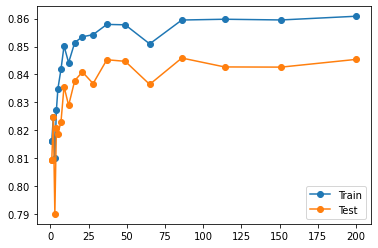

In [18]:
# define lists to collect scores
train_scores, test_scores = list(), list()

# define the estimators to evaluate
values = np.geomspace(1, 200, num=20, dtype=int)
#values = range(1, 200, 20)
for i in values:
    # create and train model on training data
    overfit_model = create_model(hiddenLayerOne=10, learnRate=0.1)
    overfit_model.fit(train_features, train_targets, epochs=i, batch_size=128)
    
    # evaluate on the train dataset
    prediction_train = overfit_model.predict_classes(train_features)
    train_auc = roc_auc_score(train_targets, prediction_train)
    train_scores.append(train_auc)
    
    # evaluate on the test dataset
    prediction_test = overfit_model.predict_classes(test_features)
    test_auc = roc_auc_score(test_targets, prediction_test)
    test_scores.append(test_auc)
    
    # summarize progress
    print('n_estimator: %.0f, train: %.3f, test: %.3f' % (i, train_auc, test_auc))
# plot of train and test scores vs n_estimator
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [ ]:
#### Overfitting conclusion:
We can conclude that ~100 epochs results in the highest validation AUC, although the performance gain after 70 epocs is very small. Buy given the relatively short running time of this model, we decide to use 100 epochs in the final model.

## Final Model
Run model using the best hyperparameter combination and 100 eopchs. Compute AUC for model comparison purposes.

Epoch 1/100
58/58 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7982
Epoch 2/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3949 - accuracy: 0.8129
Epoch 3/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3874 - accuracy: 0.8171
Epoch 4/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3808 - accuracy: 0.8289
Epoch 5/100
58/58 [==============================] - 0s 860us/step - loss: 0.3696 - accuracy: 0.8377
Epoch 6/100
58/58 [==============================] - 0s 808us/step - loss: 0.3652 - accuracy: 0.8388
Epoch 7/100
58/58 [==============================] - 0s 859us/step - loss: 0.3624 - accuracy: 0.8389
Epoch 8/100
58/58 [==============================] - 0s 825us/step - loss: 0.3617 - accuracy: 0.8371
Epoch 9/100
58/58 [==============================] - 0s 791us/step - loss: 0.3614 - accuracy: 0.8408
Epoch 10/100
58/58 [==============================] - 0s 860us/step - loss: 0.3560 - accuracy: 0.84

58/58 [==============================] - 0s 846us/step - loss: 0.3351 - accuracy: 0.8551
Epoch 82/100
58/58 [==============================] - 0s 910us/step - loss: 0.3329 - accuracy: 0.8592
Epoch 83/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3354 - accuracy: 0.8567
Epoch 84/100
58/58 [==============================] - 0s 1ms/step - loss: 0.3362 - accuracy: 0.8555
Epoch 85/100
58/58 [==============================] - 0s 843us/step - loss: 0.3342 - accuracy: 0.8565
Epoch 86/100
58/58 [==============================] - 0s 756us/step - loss: 0.3366 - accuracy: 0.8564
Epoch 87/100
58/58 [==============================] - 0s 808us/step - loss: 0.3337 - accuracy: 0.8580
Epoch 88/100
58/58 [==============================] - 0s 903us/step - loss: 0.3343 - accuracy: 0.8547
Epoch 89/100
58/58 [==============================] - 0s 859us/step - loss: 0.3341 - accuracy: 0.8565
Epoch 90/100
58/58 [==============================] - 0s 843us/step - loss: 0.3356 - accuracy: 0.85

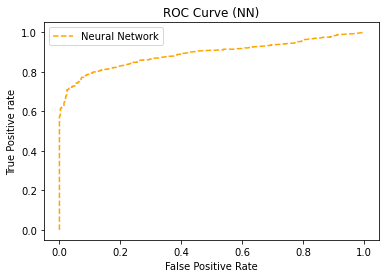

AUC Score: 0.89


In [15]:
# create final model
fin_model = create_model(hiddenLayerOne=10, learnRate=0.1)

# fit model on the dataset
fin_model.fit(train_features, train_targets, epochs=100, batch_size=128)

# predict marketing success for test dataset
predictions = fin_model.predict_classes(test_features)
    
# print conf mat and classification report
print("Confusion Matrix:")
print(confusion_matrix(test_targets, predictions))
print("Classification Report")
print(classification_report(test_targets, predictions))

# plot ROC-curve
pred_prob = fin_model.predict(test_features)
fpr, tpr, thresh = roc_curve(test_targets, pred_prob, pos_label=1) #[:,1]
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Neural Network')

# title
plt.title('ROC Curve (NN)')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();
    
# AUC Score
auc_score = roc_auc_score(test_targets, pred_prob) #[:,1]
print("AUC Score: " + str(np.round(auc_score , 3)))